In [47]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import cartopy.feature as cf

import tensorflow as tf 
from tensorflow import keras

from pyproj import Transformer
from glob import glob
from satpy import Scene

from scipy.ndimage.filters import uniform_filter

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

## a) First look at the prediction domain

In [48]:
# Starting with the lat/lon coordinates of Johannesburg.
j_burg_lon = 28.0
j_burg_lat = -26.2 

# The MSG satellite is a geostationary satellite and therefore has its own coordinate projection.
# We need to define this and then convert all our coordinate reference frames into the msg_projection.
msg_projection = ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831)
transformer_from_latlon = Transformer.from_crs("EPSG:4326", msg_projection.to_proj4(), always_xy=True)
j_burg_x, j_burg_y = transformer_from_latlon.transform(j_burg_lon,j_burg_lat)

In [49]:
# x_coords and y_coords contain the msg_projection x and y coordinates for all of the pixels within an msg image, constrained to the prediction domain (see images below).
# They have been extracted from an example image and saved for ease.
x_coords = np.load('sa_x_values.npy')
y_coords = np.load('sa_y_values.npy')

# extracting the limits of the red domain
x_min, x_max, y_min, y_max = x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()

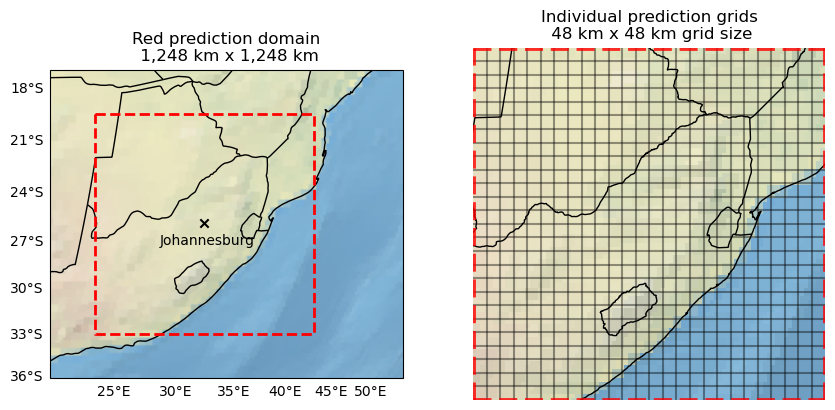

In [50]:
# This is a plotting cell that shows us our prediction domain for South Africa.
# The image on the left shows the prediction domain nested within a larger region of Southern Africa.
# The image on the right shows all of the 48 km x 48 km prediction grids that make up the prediction domain. 
# You don't need to worry about understanding the below code. Just run this cell to see the images.

fig = plt.figure(figsize=(10, 5))

# left hand image
ax = fig.add_subplot(121, projection=msg_projection)
ax.coastlines()
ax.stock_img()

gls = ax.gridlines(draw_labels=True, linewidth=0)
gls.top_labels = gls.right_labels = False

ax.set(xlim=[x_min-250_000,x_max+500_000], ylim=[y_min-250_000,y_max+250_000],transform=msg_projection)
ax.scatter(j_burg_x,j_burg_y,color='black', marker='x', transform=msg_projection)
ax.text(j_burg_x-250_000,j_burg_y-125_000,'Johannesburg', transform=msg_projection)
ax.plot([x_min, x_max, x_max, x_min, x_min], [y_max, y_max, y_min, y_min, y_max],color='red', linewidth=2, linestyle='--',transform=msg_projection)
ax.set_title('Red prediction domain\n 1,248 km x 1,248 km') 
ax.add_feature(cf.BORDERS)

# right hand image
ax = fig.add_subplot(122, projection=msg_projection)
ax.coastlines()
ax.stock_img()
ax.set(xlim=[x_min,x_max], ylim=[y_min,y_max], transform=msg_projection)
ax.set_title('Individual prediction grids\n 48 km x 48 km grid size')
ax.add_feature(cf.BORDERS)
ax.axis('off')

y_intervals = (y_max - y_min)/26
x_intervals = (x_max - x_min)/26

for i in range(1,26):
    ax.axhline(y_min+i*y_intervals,color='black', alpha=0.4)
    ax.axvline(x_min+i*x_intervals,color='black', alpha=0.4)
    
ax.axhline(y_min ,color='red',linewidth=3.5,linestyle='dashed', alpha=0.8)
ax.axhline(y_min+26*y_intervals,color='red',linewidth=3.5,linestyle='dashed', alpha=0.8)
ax.axvline(x_min,color='red',linewidth=3.5,linestyle='dashed', alpha=0.8)
ax.axvline(x_min+26*x_intervals,color='red',linewidth=3.5,linestyle='dashed', alpha=0.8)

plt.show()

## b) Next, look at the Brightness Temperature data

In [51]:
# pre-set the filepath for the BT data directory
data_path = './test_data/'

In [52]:
# Here we load the BT files from the above directory. Each file is a BT 10.6 µm image from the MSG satellite, separated by 1 hour.
# T_minus_1 is 1 hour ago, T_minus_0 is the current time and T_plus_1 is from an hour ahead (of the nowcast initialisation).
# T_minus_1 and T_minus_0 are used as inputs for SII-NowNet, whereas T_plus_1 is used for verification of the SII-NowNet nowcast.
# Obviously, T_plus_1 can only be used when looking at historical cases and not for live nowcasting.

T_minus_1_data = np.load(data_path + 'T-1_hour_BT_data.npy')
T_minus_0_data = np.load(data_path + 'T-0_hour_BT_data.npy')
T_plus_1_data = np.load(data_path + 'T+1_hour_BT_data.npy')

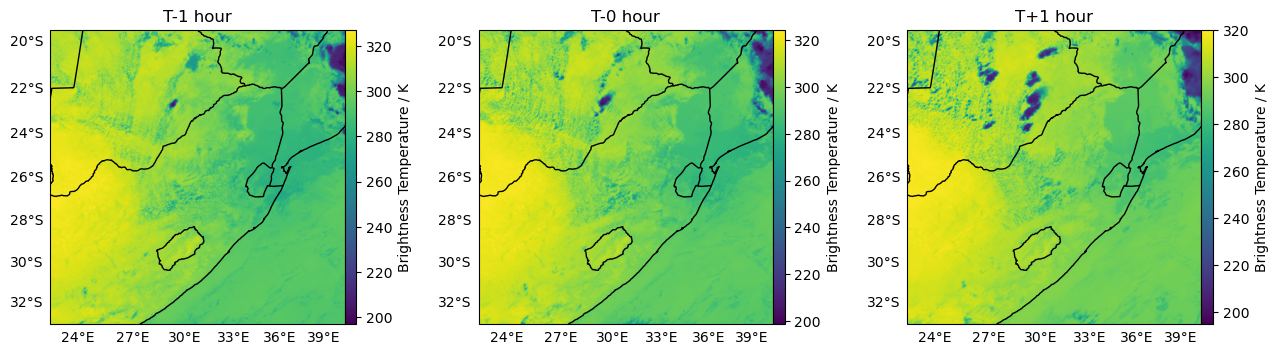

In [53]:
# A plotting cell to look at each BT image as they progress in time from T-1 to T+1. 

fig = plt.figure(figsize=(15,4))
titles = ['T-1 hour', 'T-0 hour', 'T+1 hour']

for i, BT_data in enumerate([T_minus_1_data, T_minus_0_data, T_plus_1_data]):

    ax = fig.add_subplot(1,3,i+1,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))
    ax.coastlines()
    ax.set(xlim=[x_coords.min(), x_coords.max()], ylim=[y_coords.min(), y_coords.max()], transform=msg_projection)
    im= ax.imshow(BT_data, origin = 'lower', transform=msg_projection, extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
    gl = ax.gridlines(draw_labels=True, linewidth=0)
    gl.right_labels = gl.top_labels = False
    ax.add_feature(cfeature.BORDERS, zorder=10)
    ax.set_title(titles[i])
    
    divider = make_axes_locatable(ax)
    plt.colorbar(mpl.cm.ScalarMappable(norm = mpl.colors.Normalize(vmin=BT_data.min(), vmax=BT_data.max())), 
                 label='Brightness Temperature / K',extend='neither', 
                 cax=make_axes_locatable(ax).append_axes("right", size="4%", pad=0, axes_class=maxes.Axes))

plt.subplots_adjust(wspace=0.4)

## c) Now we preparing the input data

In [54]:
# The BT data must be normalised (between 0 and 1) before it can be inputted into SII-NowNet
# max_val and min_val are pre-defined and were obtained during SII-NowNet development. They must not be changed.
max_val = 327.67
min_val = 177.81

def normalize(array, max_val, min_val):
    
    array = (array - min_val) / (max_val - min_val + 1e-13)
    
    return array

In [55]:
# Stack T_minus_1 and T_minus_0 together and then apply the normalisation
# Note: The order of stacking is important, T_minus_1 must go first
input_data = np.dstack([T_minus_1_data, T_minus_0_data])[:,:,:]
input_data = normalize(input_data, max_val, min_val)[np.newaxis]

In [56]:
# The shape of the input should be (1, 416, 416, 2)
print(input_data.shape)

(1, 416, 416, 2)


## d) We can now run SII-NowNet to generate nowcast

In [57]:
# For this example we will look at a 1 hour lead time nowcast - other lead times are available for SII-NowNet (see /models directory)
lead_time = '1'

In [58]:
# First load and apply the initiation SII-NowNet model - don't worry if a warning appears, this is normal and can be ignored
initiation_model = tf.keras.models.load_model('./models/initiation/' + lead_time  + '_initiation', compile=False)
initiation_nowcast = initiation_model.predict(input_data)[0,:,:,0]

1/1 [==============================] - 1s 1s/step


In [59]:
# Then load and apply the intensification SII-NowNet model - don't worry if a warning appears, this is normal and can be ignored
intensification_model = tf.keras.models.load_model('./models/intensification/' + lead_time  + '_intensification', compile=False)
intensification_nowcast = intensification_model.predict(input_data)[0,:,:,0]

1/1 [==============================] - 1s 1s/step


## e) Finally, plot SII-NowNet nowcast

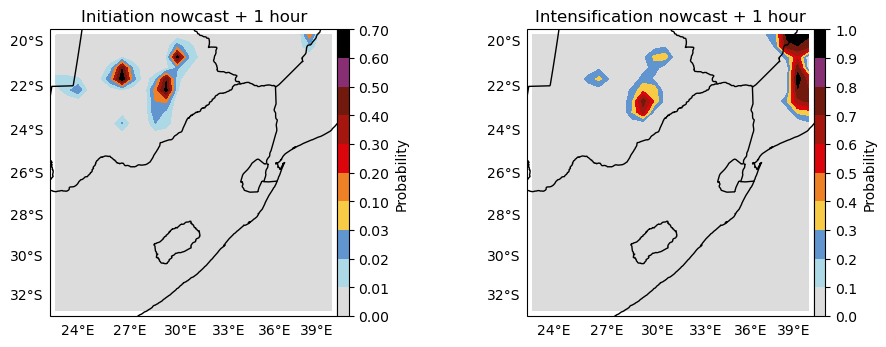

In [60]:
# This is another plotting cell to visualise the SII-NowNet nowcasts (doesn't necessarily need to be understood, just as long as it runs without error)

fig = plt.figure(figsize=(10,5))

# INITIATION
tol_precip_colors = ["gainsboro","gainsboro","lightblue", "#6195CF","#F7CB45","#EE8026","#DC050C","#A5170E","#72190E","#882E72","#000000"]
precip_colormap = mpl.colors.ListedColormap(tol_precip_colors[:])
bounds = [0,0.01,0.02,0.03,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
norm = mpl.colors.BoundaryNorm(bounds,12, extend='both')

ax = fig.add_subplot(121,projection=msg_projection)
ax.coastlines()
ax.set(xlim=[x_min, x_max], ylim=[y_min, y_max], transform=msg_projection)
im= ax.contourf(initiation_nowcast, origin = 'lower', transform=msg_projection,extent = [x_min,x_max,y_min,y_max],cmap=precip_colormap)
gl = ax.gridlines(draw_labels=True, linewidth=0)
gl.right_labels = gl.top_labels = False
ax.add_feature(cfeature.BORDERS, zorder=10)
ax.set_title('Initiation nowcast + 1 hour')

divider = make_axes_locatable(ax)
plt.colorbar(mpl.cm.ScalarMappable(cmap=precip_colormap,norm=norm), label='Probability',extend='neither',ticks=bounds, cax=make_axes_locatable(ax).append_axes("right", size="4%", pad=0, axes_class=maxes.Axes))


#INTENSIFICATION
tol_precip_colors = ["gainsboro", "lightblue", "#6195CF","#F7CB45","#EE8026","#DC050C","#A5170E","#72190E","#882E72","#000000"]
precip_colormap = mpl.colors.ListedColormap(tol_precip_colors[:])
norm = mpl.colors.Normalize(vmin=0, vmax=1)

ax = fig.add_subplot(122,projection=msg_projection)
ax.coastlines()
ax.set(xlim=[x_min, x_max], ylim=[y_min, y_max], transform=msg_projection)
im= ax.contourf(intensification_nowcast, origin = 'lower', transform=msg_projection, extent = [x_min,x_max,y_min,y_max],cmap=precip_colormap)
gl = ax.gridlines(draw_labels=True, linewidth=0)
gl.right_labels = gl.top_labels = False
ax.add_feature(cfeature.BORDERS, zorder=10)
ax.set_title('Intensification nowcast + 1 hour')

divider = make_axes_locatable(ax)
plt.colorbar(mpl.cm.ScalarMappable(cmap=precip_colormap,norm=norm), label='Probability',extend='neither',ticks=np.arange(0,1.1,0.1), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad=0, axes_class=maxes.Axes))

plt.subplots_adjust(wspace=0.6)

plt.show()

## f) Extra: verify the nowcasts to the observations (run the functions directly below this cell first)

In [64]:
def generate_convection_intensification_fields(data,
                                               change_thresh, 
                                               coverage_thresh, 
                                               bt_thresh, 
                                               target_domain_shape):

    
    bt_t1 = data[:,:,0]
    bt_t0 = data[:,:,1]
    bt_change = bt_t1 - bt_t0
    
    binary_bt_change = np.logical_and(bt_change>=change_thresh, bt_t0<=bt_thresh).astype(int)
    scaled_convection_target, grid_coverage = rescale(binary_bt_change, target_domain_shape, coverage_thresh)
    
    return scaled_convection_target

In [65]:
def generate_convection_initiation_fields(data, 
                                          change_thresh, 
                                          coverage_thresh, 
                                          bt_thresh, 
                                          kernel_size, 
                                          smooth_thresh,
                                          target_domain_shape):
            
    
    bt_t1 = data[:,:,0]
    bt_t0 = data[:,:,1] 
    
    binary_bt_t1 = np.where(bt_t1<=bt_thresh+change_thresh,1,0)
    binary_bt_t0 = np.where(bt_t0<=bt_thresh,1,0)

    smooth_bt_t1 = uniform_filter(binary_bt_t1, size=kernel_size, mode="constant", output = float, cval=0.0)
    smooth_bt_t1 = np.where(smooth_bt_t1<smooth_thresh,0,1)
    
    convection_initiation = binary_bt_t0-smooth_bt_t1
    binary_convection_initiation = np.where(convection_initiation<=0,0,1)
    
    scaled_binary_initiation, grid_coverage = rescale(binary_convection_initiation, target_domain_shape, coverage_thresh)
    
    return scaled_binary_initiation

In [66]:
def rescale(image, target_domain_shape, thresh):
    
    x_dims = int(image.shape[0]/target_domain_shape[0])
    y_dims = int(image.shape[1]/target_domain_shape[1])
    
    scaled_image = np.zeros((target_domain_shape[0], target_domain_shape[1]))
    grid_coverage = np.zeros((target_domain_shape[0], target_domain_shape[1]))

    for i in range(target_domain_shape[0]):
        
        for j in range(target_domain_shape[1]):
            
            grid_cov = np.sum(image[i*x_dims:(i+1)*x_dims, j*y_dims:(j+1)*y_dims])
            grid_coverage[i,j] = grid_cov
            
            if grid_cov >= (thresh*(x_dims**2)):
                scaled_image[i,j] = 1
    
    return scaled_image, grid_coverage

In [43]:
# Here is where we use the T_plus_1 BT data to be able to identify the 'true' initiation/intensification events and generate the observations required for verification
# Again, this cannot be done when live nowcasting (we can't actually see an hour into the future!), but is useful for verifying historical cases of SII-NowNet
obs_input_data = np.dstack([T_minus_0_data, T_plus_1_data])

In [44]:
# intensification observationsm - this function generates the observed events and doesn't need to be fully understood at this stage
intensification_observation = generate_convection_intensification_fields(obs_input_data, 20, 0.05, 235, (26,26))

In [45]:
# initiation observations - same as above cell!
initiation_observation = generate_convection_initiation_fields(obs_input_data, 20, 0.05, 235, 20, 0.05, (26,26))

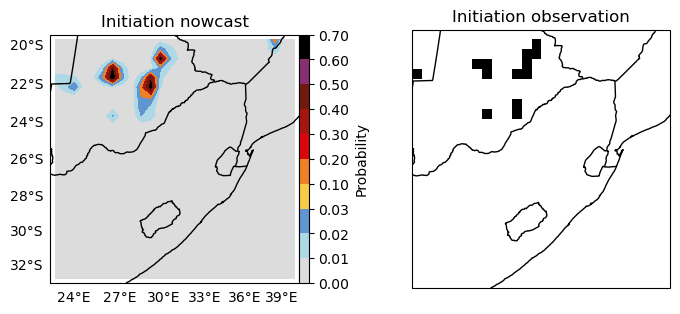

In [46]:
# Plotting cell to visually compare the SII-NowNet initiation nowcast to the observed initiation events (black squares)

tol_precip_colors = ["gainsboro","gainsboro","lightblue", "#6195CF","#F7CB45","#EE8026","#DC050C","#A5170E","#72190E","#882E72","#000000"]
precip_colormap = mpl.colors.ListedColormap(tol_precip_colors[:])
bounds = [0,0.01,0.02,0.03,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
norm = mpl.colors.BoundaryNorm(bounds,12, extend='both')

fig = plt.figure(figsize=(8,4))

# Nowcast plot
ax = fig.add_subplot(121,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))
ax.coastlines()
ax.set(xlim=[x_min, x_max], ylim=[y_min, y_max], transform=msg_projection)
im= ax.contourf(initiation_nowcast, origin = 'lower', transform=msg_projection, extent = [x_min, x_max, y_min, y_max], cmap=precip_colormap)
gl = ax.gridlines(draw_labels=True, linewidth=0)
gl.right_labels = gl.top_labels = False
ax.add_feature(cfeature.BORDERS, zorder=10)
ax.set_title('Initiation nowcast')

divider = make_axes_locatable(ax)
plt.colorbar(mpl.cm.ScalarMappable(cmap=precip_colormap,norm=norm), label='Probability',extend='neither',ticks=bounds, cax=make_axes_locatable(ax).append_axes("right", size="4%", pad=0, axes_class=maxes.Axes))

# Observation plot
ax = fig.add_subplot(122,projection=msg_projection)
ax.coastlines()
ax.set(xlim=[x_min, x_max], ylim=[y_min, y_max], transform =msg_projection)
im= ax.imshow(initiation_observation, origin = 'lower', transform=msg_projection,extent=[x_min, x_max, y_min, y_max], cmap='Greys')
ax.set_title('Initiation observation')
ax.add_feature(cfeature.BORDERS, zorder=10)

plt.subplots_adjust(wspace=0.4)

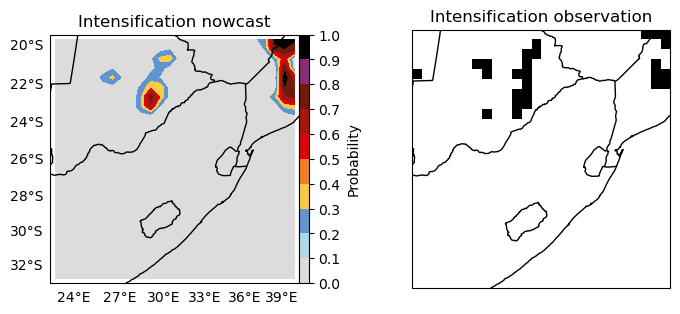

In [26]:
# Plotting cell to visually compare the SII-NowNet intensification nowcast to the observed intensification events (black squares)

tol_precip_colors = ["gainsboro", "lightblue", "#6195CF","#F7CB45","#EE8026","#DC050C","#A5170E","#72190E","#882E72","#000000"]
precip_colormap = mpl.colors.ListedColormap(tol_precip_colors[:])
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(8,4))

# Nowcast plot
ax = fig.add_subplot(121,projection=msg_projection)
ax.coastlines()
ax.set(xlim=[x_min, x_max], ylim=[y_min, y_max], transform=msg_projection)
im= ax.contourf(intensification_nowcast, origin = 'lower', transform=msg_projection, extent = [x_min, x_max, y_min, y_max], cmap=precip_colormap)
gl = ax.gridlines(draw_labels=True, linewidth=0)
gl.right_labels = gl.top_labels = False
ax.add_feature(cfeature.BORDERS, zorder=10)
ax.set_title('Intensification nowcast')

divider = make_axes_locatable(ax)
plt.colorbar(mpl.cm.ScalarMappable(cmap=precip_colormap,norm=norm), label='Probability',extend='neither',ticks=np.arange(0,1.1,0.1), cax=make_axes_locatable(ax).append_axes("right", size="4%", pad=0, axes_class=maxes.Axes))

# Observation plot
ax = fig.add_subplot(122,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))
ax.coastlines()
ax.set(xlim=[x_min, x_max], ylim=[y_min, y_max], transform =msg_projection)
im= ax.imshow(intensification_observation, origin = 'lower', transform=msg_projection, extent = [x_min, x_max, y_min, y_max], cmap='Greys')

ax.set_title('Intensification observation')
ax.add_feature(cfeature.BORDERS, zorder=10)

plt.subplots_adjust(wspace=0.4)